In [1]:
#Inverse design analysis

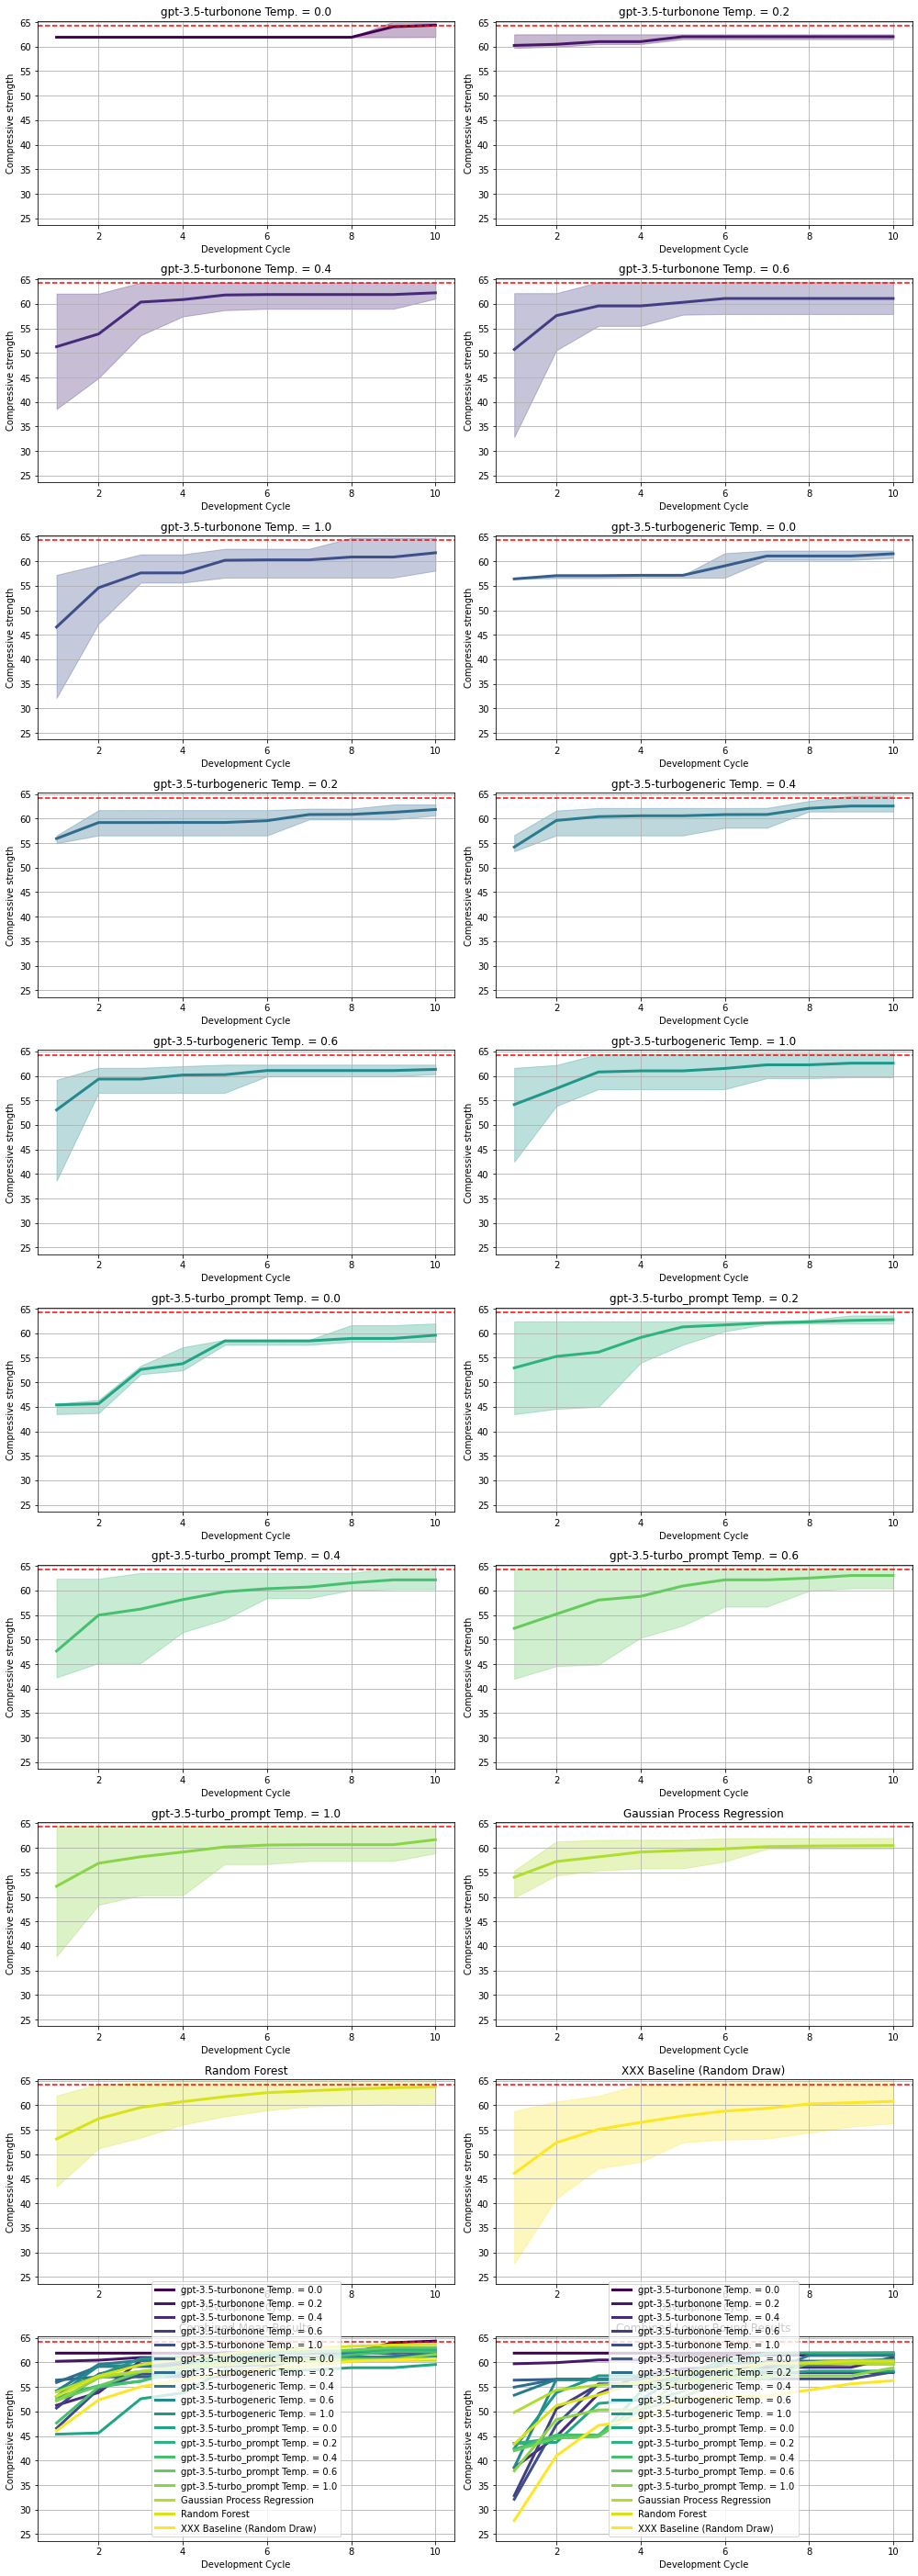

In [29]:
import pandas as pd
import numpy as np
import csv
import glob
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import math
from matplotlib import patches
from matplotlib.ticker import FuncFormatter
from ID_Utilities import (
    extract_messages,
    create_input_messages,
    generate_response,
    handle_openai_error,
    call_openai_api,
    backoff_factors,
)

import math
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#desired_strength = 61.94 # 95% quantile
desired_strength = 64.24 # 95% quantile
model_names = ['gpt-3.5-turbogeneric','gpt-3.5-turbonone',"gpt-3.5-turbo_prompt","gpt-4generic" "gpt-4",]

def load_and_process_results(budget, initial_sample_size):
    # Load previous code results
    results = {}

    for model in model_names:
        files = glob.glob(f"Results/ID/{model}_*.csv")

        for file in files:
            # Extract temp from filename
            temp = float(file.split("_temp_")[1].split("_")[0])
            
            # Load results
            df = pd.read_csv(file)
            
            # Get 'Compressive Strength' column
            strengths = df['Compressive Strength'].values.tolist()
            
            # Extend the list to the budget length if needed
            while len(strengths) < budget:
                strengths.append(strengths[-1])
            
            # Add to results dictionary
            key = ('AI', model, temp)  # AI configuration
            if key not in results:
                results[key] = []
            results[key].append(strengths)
 
    # Load Bayesian optimization baseline results
    files = glob.glob("results/BO/*.csv")
    for file in files:
        # Extract experiment and kernel from filename
        initsamp = int(file.split("_initialsample_")[1].split("_")[0])
        kernel = file.split("_kernel_")[1].split("_")[0]
        
        # Use experiment and kernel as key
        key = ('Gaussian Process Regression', initsamp, kernel)  # BO configuration
        
        # Load results
        df = pd.read_csv(file)
        
        # Get 'Compressive Strength' column and discard initial samples
        strengths = df['fc_28dGroundTruth'].values.tolist()[initial_sample_size:]
        
        # Extend the list to the budget length if needed
        while len(strengths) < budget:
            strengths.append(strengths[-1])
        
        # Add to results dictionary
        if key not in results:
            results[key] = []
        results[key].append(strengths)
        
    # Load RF baseline results
    files = glob.glob("results/RF_ID/*.csv")
    for file in files:
        # Extract experiment and kernel from filename
        initsamp = int(file.split("_initialsample_")[1].split("_")[0])
        kernel = 'Random Forest'
        
        # Use experiment and kernel as key
        key = ('Random Forest', initsamp, kernel)  # BO configuration
        
        # Load results
        df = pd.read_csv(file)
        
        # Get 'Compressive Strength' column and discard initial samples
        strengths = df['fc_28dGroundTruth'].values.tolist()[initial_sample_size:]
        
        # Extend the list to the budget length if needed
        while len(strengths) < budget:
            strengths.append(strengths[-1])
        
        # Add to results dictionary
        if key not in results:
            results[key] = []
        results[key].append(strengths)
        
    # Load RP baseline results
    files = glob.glob("results/RP_ID/*.csv")
    for file in files:
        # Extract experiment and kernel from filename
        initsamp = ''
        kernel = 'Random (Baseline)'
        
        # Use experiment and kernel as key
        key = ('XXX Baseline (Random Draw)', initsamp, kernel)  # BO configuration
        
        # Load results
        df = pd.read_csv(file)
        
        # Get 'Compressive Strength' column and discard initial samples
        strengths = df['fc_28dGroundTruth'].values.tolist()
        
        # Extend the list to the budget length if needed
        
        while len(strengths) < budget:
            strengths.append(strengths[-1])
        
        # Add to results dictionary
        if key not in results:
            results[key] = []
        results[key].append(strengths)    
        
    return results


def plot_results(results, desired_target):
    def sorting_key(item):
        config_type, model_name, value = item[0]

        try:  # try to convert value part of the key to float (temperature or initial sample size)
            value = float(value)
        except ValueError:  # if it fails (due to being a string), assign infinity
            value = float('inf')

        # Try to differentiate models, if not possible treat them as equal (0)
        model_value = {'gpt-3.5-turbonone':1,'gpt-3.5-turbogeneric':2,'gpt-3.5-turbo_prompt': 3,'gpt-4generic':4, 'gpt-4': 5}.get(model_name, 0)

        return (config_type, model_value, value)

    # Sort the results
    sorted_results = dict(sorted(results.items(), key=sorting_key, reverse=False))

    # Calculate the number of rows and columns for the subplot grid
    num_configs = len(sorted_results.keys())
    num_columns = 2
    num_rows = math.ceil((num_configs + 2) / num_columns)  # Add 2 for the combined mean and lower bound plots

    # Define the layout of the plots
    num_columns = 2
    num_rows = (len(results) + 2) // num_columns + 1 if (len(results) + 2) % num_columns != 0 else (len(results) + 2) // num_columns


    # Set up plot
    fig = plt.figure(figsize=(num_columns*7, num_rows*4))
    gs = gridspec.GridSpec(num_rows, num_columns)

    y_min = np.inf  # initialize global minimum y
    y_max = -np.inf  # initialize global maximum y

    for i, ((config_type, model, temp), all_strengths) in enumerate(results.items()):
        #ax = fig.add_subplot(gs[i // num_columns, i % num_columns])
        # Calculate cumulative max for each experiment
        all_strengths = [np.maximum.accumulate(str) for str in all_strengths]

        # Get global minimum and maximum y-values
        y_min = min(y_min, np.min([np.min(str) for str in all_strengths]))
        y_max = max(y_max, np.max([np.max(str) for str in all_strengths]))

        # Calculate and plot mean and lower bound for each experiment

    
    
    # Initialize a grid for the subplots
    gs = gridspec.GridSpec(num_rows, num_columns)

    # Normalize y-axis across all subplots
    max_strength = max([max(np.maximum.accumulate(strengths)) for all_strengths in sorted_results.values() for strengths in all_strengths])
    min_strength = min([min(np.maximum.accumulate(strengths)) for all_strengths in sorted_results.values() for strengths in all_strengths])

    colors = plt.cm.viridis(np.linspace(0, 1, num_configs))  # color map for different configurations
    
    for i, ((config_type, model, temp), strengths) in enumerate(sorted_results.items()):
        # Calculate cumulative max for each experiment
        all_strengths = [np.maximum.accumulate(str) for str in strengths]

        # Calculate the mean and the 10th and 90th percentiles
        mean_strengths = np.mean(all_strengths, axis=0)
        lower_bound = np.percentile(all_strengths, 10, axis=0)
        upper_bound = np.percentile(all_strengths, 90, axis=0)
        
        iterations = list(range(1, len(mean_strengths) + 1))

        # Plot individual subplots in a 2-column layout
        ax = fig.add_subplot(gs[i // num_columns, i % num_columns])
        color = colors[i]  # get color for this configuration
        
        
        if config_type == 'AI':  # Bayesian optimization results
            ax.plot(iterations, mean_strengths, color=color, label=f'{model} Temp. = {temp}', linewidth=3)
        else:  # AI results
            ax.plot(iterations, mean_strengths, color=color, label=f'{config_type}', linewidth=3)
        ax.fill_between(iterations, lower_bound, upper_bound, alpha=0.3, color=color)
        
        # Add horizontal line for the desired target strength
        ax.axhline(y=desired_target, color='r', linestyle='--')
        
        # Normalize y-axis
        ax.set_ylim([y_min, y_max])
        # Add labels, title and legend
        ax.set_xlabel('Development Cycle')
        ax.set_ylabel('Compressive strength')
        if config_type == 'AI':  # Bayesian optimization results
            ax.set_title(f'{model} Temp. = {temp}')
        else:  # AI results
            ax.set_title(f'{config_type}')
        #ax.set_title(f'{config_type} {model} Temperature = {temp}')
        #ax.legend()
        ax.grid(True)
    
    # Add combined plot with mean results
    ax_combined_mean = fig.add_subplot(gs[(i+1) // num_columns, (i+1) % num_columns])
    for i, ((config_type, model, temp), all_strengths) in enumerate(sorted_results.items()):
        # Calculate cumulative max for each experiment
        all_strengths = [np.maximum.accumulate(str) for str in all_strengths]

        # Calculate the mean 
        mean_strengths = np.mean(all_strengths, axis=0)

        iterations = list(range(1, len(mean_strengths) + 1))

        # Plot combined results
        color = colors[i]  # get color for this configuration
        if config_type == 'AI':  # Bayesian optimization results
            ax_combined_mean.plot(iterations, mean_strengths, color=color, label=f'{model} Temp. = {temp}', linewidth=3)
        else:  # AI results
            ax_combined_mean.plot(iterations, mean_strengths, color=color, label=f'{config_type}', linewidth=3)

    ax_combined_mean.axhline(y=desired_target, color='r', linestyle='--')
    ax_combined_mean.set_xlabel('Development Cycle')
    ax_combined_mean.set_ylabel('Compressive strength')
    ax_combined_mean.set_title('Combined Mean Results')
    ax_combined_mean.set_ylim([y_min, y_max])
    ax_combined_mean.legend()
    ax_combined_mean.grid(True)

    # Add combined plot with lower bound results
    ax_combined_lower = fig.add_subplot(gs[(i+2) // num_columns, (i+2) % num_columns])
    for i, ((config_type, model, temp), all_strengths) in enumerate(sorted_results.items()):
        # Calculate cumulative max for each experiment
        all_strengths = [np.maximum.accumulate(str) for str in all_strengths]

        # Calculate the lower bound
        lower_bound = np.percentile(all_strengths, 10, axis=0)

        iterations = list(range(1, len(lower_bound) + 1))

        # Plot combined results
        color = colors[i]  # get color for this configuration
        if config_type == 'AI':  # Bayesian optimization results
            ax_combined_lower.plot(iterations, lower_bound, color=color, label=f'{model} Temp. = {temp}', linewidth=3)
        else:  # AI results
            ax_combined_lower.plot(iterations, lower_bound, color=color, label=f'{config_type}', linewidth=3)

    ax_combined_lower.axhline(y=desired_target, color='r', linestyle='--')
    ax_combined_lower.set_xlabel('Development Cycle')
    ax_combined_lower.set_ylabel('Compressive strength')
    ax_combined_lower.set_title('Combined Lower Bound Results')
    ax_combined_lower.set_ylim([y_min, y_max])
    ax_combined_lower.legend()
    ax_combined_lower.grid(True)
    plt.tight_layout()
    plt.show()
    

# Load and process the results
results = load_and_process_results(budget=10, initial_sample_size=4)
# Plot the results
plot_results(results, desired_strength)


In [31]:
import pandas as pd
import numpy as np
import glob

# Define your variables here
model_names = ['gpt-3.5-turbogeneric','gpt-3.5-turbonone',"gpt-3.5-turbo_prompt","gpt-4generic" "gpt-4",]
budget = 10
initial_sample_size = 4

# Load and process the results
results = load_and_process_results(budget, initial_sample_size)

# Function for sorting
def sorting_key(item):
    config_type, model_name, value = item[0]

    try:  # try to convert value part of the key to float (temperature or initial sample size)
        value = float(value)
    except ValueError:  # if it fails (due to being a string), assign infinity
        value = float('inf')

    # Try to differentiate models, if not possible treat them as equal (0)
    model_value = {'gpt-3.5-turbonone':1,'gpt-3.5-turbogeneric':2,'gpt-3.5-turbo_prompt': 3,'gpt-4generic':4, 'gpt-4': 5}.get(model_name, 0)

    return (config_type, model_value, value)

# Sort the results
sorted_results = dict(sorted(results.items(), key=sorting_key, reverse=False))

# Initialize data collectors
mean_performance_table = pd.DataFrame()
lower_bound_performance_table = pd.DataFrame()
success_rate_table = pd.DataFrame()

# Iterate over the sorted results
for ((config_type, model, temp), all_strengths) in sorted_results.items():
    # Calculate cumulative max for each experiment
    all_strengths = [np.maximum.accumulate(str) for str in all_strengths]

    # Calculate the mean and the lower bound
    mean_strengths = np.mean(all_strengths, axis=0)  # don't round here
    lower_bound_strengths = np.percentile(all_strengths, 10, axis=0)  # don't round here

    # Construct model name based on config_type
    if config_type == 'AI':  # Bayesian optimization results
        model_name = f'{model} Temp. = {temp}'  # trim model name
    else:  # AI results
        model_name = f'{config_type}'

    # Add to performance tables
    mean_performance_table = pd.concat([mean_performance_table, pd.DataFrame({"Model Name": [model_name], **{f"Cycle {i+1}": [mean_strengths[i] * 100 / desired_strength] for i in range(10)}})], ignore_index=True)
    lower_bound_performance_table = pd.concat([lower_bound_performance_table, pd.DataFrame({"Model Name": [model_name], **{f"Cycle {i+1}": [lower_bound_strengths[i] * 100 / desired_strength] for i in range(10)}})], ignore_index=True)

    # Calculate success rates
    success_rates = [np.mean([np.any(np.array(strengths[:i+1]) > desired_strength) for strengths in all_strengths]) for i in range(len(all_strengths[0]))]
    success_rate_table = pd.concat([success_rate_table, pd.DataFrame({"Model Name": [model_name], **{f"Cycle {i+1}": [success_rates[i] * 100] for i in range(10)}})], ignore_index=True)

# Calculate and append the average performance for the first 5 rounds and the last 5 rounds
mean_performance_table["Avg Performance (Rounds 1-5)"] = mean_performance_table.iloc[:, 1:6].mean(axis=1)
mean_performance_table["Avg Performance (Rounds 6-10)"] = mean_performance_table.iloc[:, 6:11].mean(axis=1)
lower_bound_performance_table["Avg Performance (Rounds 1-5)"] = lower_bound_performance_table.iloc[:, 1:6].mean(axis=1)
lower_bound_performance_table["Avg Performance (Rounds 6-10)"] = lower_bound_performance_table.iloc[:, 6:11].mean(axis=1)
success_rate_table["Avg Success Rate (Rounds 1-5)"] = success_rate_table.iloc[:, 1:6].mean(axis=1)
success_rate_table["Avg Success Rate (Rounds 6-10)"] = success_rate_table.iloc[:, 6:11].mean(axis=1)

mean_performance_table.to_csv('Results/mean_performance_table.csv', index=False)
lower_bound_performance_table.to_csv('Results/lower_bound_performance_table.csv', index=False)
success_rate_table.to_csv('Results/success_rate_table.csv', index=False)

# Highlight functions
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

def highlight_second_max(s):
    s_sorted = s.sort_values(ascending=False)
    second_max = s_sorted.iloc[1] if len(s_sorted) > 1 else None
    return ['text-decoration: underline' if v == second_max else '' for v in s]

# Apply highlight and then formatting
mean_performance_table_styled = mean_performance_table.style.apply(highlight_max).apply(highlight_second_max)
mean_performance_table_styled.format("{:.1f}", subset=pd.IndexSlice[:, mean_performance_table.columns[1:]])

lower_bound_performance_table_styled = lower_bound_performance_table.style.apply(highlight_max).apply(highlight_second_max)
lower_bound_performance_table_styled.format("{:.1f}", subset=pd.IndexSlice[:, lower_bound_performance_table.columns[1:]])

success_rate_table_styled = success_rate_table.style.apply(highlight_max).apply(highlight_second_max)
success_rate_table_styled.format("{:.1f}", subset=pd.IndexSlice[:, success_rate_table.columns[1:]])

# Display the tables
print("Mean Performance Table:")
display(mean_performance_table_styled)

print("\nLower Bound Performance Table:")
display(lower_bound_performance_table_styled)

print("\nSuccess Rate Table:")
display(success_rate_table_styled)


Mean Performance Table:


,Model Name,Cycle 1,Cycle 2,Cycle 3,Cycle 4,Cycle 5,Cycle 6,Cycle 7,Cycle 8,Cycle 9,Cycle 10,Avg Performance (Rounds 1-5),Avg Performance (Rounds 6-10)
0,gpt-3.5-turbonone Temp. = 0.0,96.4,96.4,96.4,96.4,96.4,96.4,96.4,96.4,99.7,100.2,96.4,97.8
1,gpt-3.5-turbonone Temp. = 0.2,93.8,94.1,95.0,95.0,96.5,96.5,96.5,96.5,96.5,96.5,94.9,96.5
2,gpt-3.5-turbonone Temp. = 0.4,79.8,83.9,94.0,94.8,96.2,96.4,96.4,96.4,96.4,96.9,89.7,96.5
3,gpt-3.5-turbonone Temp. = 0.6,78.9,89.7,92.8,92.8,93.9,95.1,95.1,95.1,95.1,95.1,89.6,95.1
4,gpt-3.5-turbonone Temp. = 1.0,72.5,85.0,89.7,89.7,93.7,93.8,93.8,94.7,94.7,96.1,86.1,94.6
5,gpt-3.5-turbogeneric Temp. = 0.0,87.8,88.8,88.8,88.9,88.9,91.9,95.1,95.1,95.1,95.8,88.7,94.6
6,gpt-3.5-turbogeneric Temp. = 0.2,87.1,92.1,92.1,92.2,92.2,92.7,94.7,94.7,95.4,96.3,91.1,94.8
7,gpt-3.5-turbogeneric Temp. = 0.4,84.4,92.8,94.0,94.3,94.3,94.7,94.7,96.7,97.4,97.4,92.0,96.2
8,gpt-3.5-turbogeneric Temp. = 0.6,82.6,92.4,92.4,93.7,93.8,95.1,95.1,95.1,95.1,95.5,91.0,95.2
9,gpt-3.5-turbogeneric Temp. = 1.0,84.3,89.4,94.6,95.0,95.0,95.8,96.9,96.9,97.4,97.4,91.7,96.9



Lower Bound Performance Table:


,Model Name,Cycle 1,Cycle 2,Cycle 3,Cycle 4,Cycle 5,Cycle 6,Cycle 7,Cycle 8,Cycle 9,Cycle 10,Avg Performance (Rounds 1-5),Avg Performance (Rounds 6-10)
0,gpt-3.5-turbonone Temp. = 0.0,96.4,96.4,96.4,96.4,96.4,96.4,96.4,96.4,96.4,96.4,96.4,96.4
1,gpt-3.5-turbonone Temp. = 0.2,93.0,93.3,94.2,94.2,95.8,95.8,95.8,95.8,95.8,95.8,94.1,95.8
2,gpt-3.5-turbonone Temp. = 0.4,60.0,69.9,83.4,89.4,91.4,91.9,91.9,91.9,91.9,95.1,78.8,92.5
3,gpt-3.5-turbonone Temp. = 0.6,51.1,78.7,86.4,86.4,90.0,90.2,90.2,90.2,90.2,90.2,78.5,90.2
4,gpt-3.5-turbonone Temp. = 1.0,50.0,73.6,86.6,86.6,88.2,88.2,88.2,88.2,88.2,90.4,77.0,88.6
5,gpt-3.5-turbogeneric Temp. = 0.0,87.8,88.0,88.0,88.2,88.2,88.2,93.8,93.8,93.8,94.5,88.0,92.8
6,gpt-3.5-turbogeneric Temp. = 0.2,85.6,88.0,88.0,88.0,88.0,88.0,93.1,93.1,93.1,94.4,87.5,92.4
7,gpt-3.5-turbogeneric Temp. = 0.4,83.0,88.0,88.0,88.0,88.0,90.5,90.5,95.6,95.6,95.6,87.0,93.6
8,gpt-3.5-turbogeneric Temp. = 0.6,60.1,88.0,88.0,88.0,88.0,93.2,93.2,93.2,93.2,93.9,82.5,93.4
9,gpt-3.5-turbogeneric Temp. = 1.0,66.2,83.8,89.2,89.2,89.2,89.2,92.7,92.7,93.0,93.0,83.5,92.1



Success Rate Table:


,Model Name,Cycle 1,Cycle 2,Cycle 3,Cycle 4,Cycle 5,Cycle 6,Cycle 7,Cycle 8,Cycle 9,Cycle 10,Avg Success Rate (Rounds 1-5),Avg Success Rate (Rounds 6-10)
0,gpt-3.5-turbonone Temp. = 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,80.0,0.0,30.0
1,gpt-3.5-turbonone Temp. = 0.2,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,gpt-3.5-turbonone Temp. = 0.4,0.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,12.0,20.0
3,gpt-3.5-turbonone Temp. = 0.6,10.0,10.0,20.0,20.0,20.0,30.0,30.0,30.0,30.0,30.0,16.0,30.0
4,gpt-3.5-turbonone Temp. = 1.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0,20.0,20.0,30.0,2.0,18.0
5,gpt-3.5-turbogeneric Temp. = 0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0,10.0,0.0,8.0
6,gpt-3.5-turbogeneric Temp. = 0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,0.0,4.0
7,gpt-3.5-turbogeneric Temp. = 0.4,0.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,20.0,20.0,6.0,14.0
8,gpt-3.5-turbogeneric Temp. = 0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,gpt-3.5-turbogeneric Temp. = 1.0,10.0,10.0,20.0,20.0,20.0,30.0,40.0,40.0,40.0,40.0,16.0,38.0


In [35]:
# Define your variables here
model_names = ['gpt-3.5-turbogeneric', 'gpt-3.5-turbonone', "gpt-3.5-turbo_prompt", "gpt-4generic", "gpt-4",]
budget = 10
initial_sample_size = 4

# Load and process the results
results = load_and_process_results(budget, initial_sample_size)

# Load the distribution data
distribution_data = pd.read_csv('Data/DiscoveryData_Sample.csv')
distribution = np.sort(distribution_data['fc_28dGroundTruth'].values)
# Function for sorting
def sorting_key(item):
    config_type, model_name, value = item[0]

    try:  # try to convert value part of the key to float (temperature or initial sample size)
        value = float(value)
    except ValueError:  # if it fails (due to being a string), assign infinity
        value = float('inf')

    # Try to differentiate models, if not possible treat them as equal (0)
    model_value = {'gpt-3.5-turbonone':1, 'gpt-3.5-turbogeneric':2, 'gpt-3.5-turbo_prompt': 3, 'gpt-4generic':4, 'gpt-4': 5}.get(model_name, 0)

    return (config_type, model_value, value)

# Sort the results
sorted_results = dict(sorted(results.items(), key=sorting_key, reverse=False))

# Initialize data collectors
mean_performance_table = pd.DataFrame()
lower_bound_performance_table = pd.DataFrame()
success_rate_table = pd.DataFrame()

# Iterate over the sorted results
for ((config_type, model, temp), all_strengths) in sorted_results.items():
    # Calculate cumulative max for each experiment
    all_strengths = [np.maximum.accumulate(str) for str in all_strengths]

    # Calculate the percentiles based on your specific distribution
    percentile_strengths = [(np.abs(distribution - strength).argmin() / len(distribution)) * 100 for strength in np.mean(all_strengths, axis=0)]

    # Construct model name based on config_type
    if config_type == 'AI':  # Bayesian optimization results
        model_name = f'{model} Temp. = {temp}'  # trim model name
    else:  # AI results
        model_name = f'{config_type}'

    # Add to performance tables
    mean_performance_table = pd.concat([mean_performance_table, pd.DataFrame({"Model Name": [model_name], **{f"Cycle {i+1}": [percentile_strengths[i]] for i in range(10)}})], ignore_index=True)

    # Calculate success rates
    success_rates = [np.mean([np.any(np.array(strengths[:i+1]) > desired_strength) for strengths in all_strengths]) for i in range(len(all_strengths[0]))]
    success_rate_table = pd.concat([success_rate_table, pd.DataFrame({"Model Name": [model_name], **{f"Cycle {i+1}": [success_rates[i] * 100] for i in range(10)}})], ignore_index=True)

# Calculate and append the average performance for the first 5 rounds and the last 5 rounds
mean_performance_table["Avg Performance (Rounds 1-5)"] = mean_performance_table.iloc[:, 1:6].mean(axis=1)
mean_performance_table["Avg Performance (Rounds 6-10)"] = mean_performance_table.iloc[:, 6:11].mean(axis=1)
success_rate_table["Avg Success Rate (Rounds 1-5)"] = success_rate_table.iloc[:, 1:6].mean(axis=1)
success_rate_table["Avg Success Rate (Rounds 6-10)"] = success_rate_table.iloc[:, 6:11].mean(axis=1)

mean_performance_table.to_csv('Results/mean_performance_table.csv', index=False)
success_rate_table.to_csv('Results/success_rate_table.csv', index=False)

# Highlight functions
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

def highlight_second_max(s):
    s_sorted = s.sort_values(ascending=False)
    second_max = s_sorted.iloc[1] if len(s_sorted) > 1 else None
    return ['text-decoration: underline' if v == second_max else '' for v in s]

# Apply highlight and then formatting
mean_performance_table_styled = mean_performance_table.style.apply(highlight_max).apply(highlight_second_max)
mean_performance_table_styled.format("{:.1f}", subset=pd.IndexSlice[:, mean_performance_table.columns[1:]])

success_rate_table_styled = success_rate_table.style.apply(highlight_max).apply(highlight_second_max)
success_rate_table_styled.format("{:.1f}", subset=pd.IndexSlice[:, success_rate_table.columns[1:]])

# Display the tables
print("Mean Performance Table:")
display(mean_performance_table_styled)

print("\nSuccess Rate Table:")
display(success_rate_table_styled)


Mean Performance Table:


,Model Name,Cycle 1,Cycle 2,Cycle 3,Cycle 4,Cycle 5,Cycle 6,Cycle 7,Cycle 8,Cycle 9,Cycle 10,Avg Performance (Rounds 1-5),Avg Performance (Rounds 6-10)
0,gpt-3.5-turbonone Temp. = 0.0,94.6,94.6,94.6,94.6,94.6,94.6,94.6,94.6,97.1,97.5,94.6,95.7
1,gpt-3.5-turbonone Temp. = 0.2,91.2,92.1,92.9,92.9,95.4,95.4,95.4,95.4,95.4,95.4,92.9,95.4
2,gpt-3.5-turbonone Temp. = 0.4,61.3,69.6,91.7,92.5,94.6,94.6,94.6,94.6,94.6,95.8,81.9,94.8
3,gpt-3.5-turbonone Temp. = 0.6,58.8,82.5,87.9,87.9,91.2,92.9,92.9,92.9,92.9,92.9,81.7,92.9
4,gpt-3.5-turbonone Temp. = 1.0,45.4,71.2,82.5,82.5,90.8,91.2,91.2,92.5,92.5,94.2,74.5,92.3
5,gpt-3.5-turbogeneric Temp. = 0.0,77.5,80.4,80.4,80.4,80.4,87.1,92.9,92.9,92.9,93.8,79.8,91.9
6,gpt-3.5-turbogeneric Temp. = 0.2,75.8,87.5,87.5,87.5,87.5,87.9,92.5,92.5,93.3,94.6,85.2,92.2
7,gpt-3.5-turbogeneric Temp. = 0.4,70.0,87.9,91.7,92.1,92.1,92.5,92.5,95.4,96.2,96.2,86.8,94.6
8,gpt-3.5-turbogeneric Temp. = 0.6,67.5,87.5,87.5,90.8,91.2,92.9,92.9,92.9,92.9,93.3,84.9,93.0
9,gpt-3.5-turbogeneric Temp. = 1.0,70.0,81.7,92.5,92.9,92.9,93.8,95.8,95.8,96.2,96.2,86.0,95.6



Success Rate Table:


,Model Name,Cycle 1,Cycle 2,Cycle 3,Cycle 4,Cycle 5,Cycle 6,Cycle 7,Cycle 8,Cycle 9,Cycle 10,Avg Success Rate (Rounds 1-5),Avg Success Rate (Rounds 6-10)
0,gpt-3.5-turbonone Temp. = 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,80.0,0.0,30.0
1,gpt-3.5-turbonone Temp. = 0.2,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,gpt-3.5-turbonone Temp. = 0.4,0.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,12.0,20.0
3,gpt-3.5-turbonone Temp. = 0.6,10.0,10.0,20.0,20.0,20.0,30.0,30.0,30.0,30.0,30.0,16.0,30.0
4,gpt-3.5-turbonone Temp. = 1.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0,20.0,20.0,30.0,2.0,18.0
5,gpt-3.5-turbogeneric Temp. = 0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0,10.0,0.0,8.0
6,gpt-3.5-turbogeneric Temp. = 0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,0.0,4.0
7,gpt-3.5-turbogeneric Temp. = 0.4,0.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,20.0,20.0,6.0,14.0
8,gpt-3.5-turbogeneric Temp. = 0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,gpt-3.5-turbogeneric Temp. = 1.0,10.0,10.0,20.0,20.0,20.0,30.0,40.0,40.0,40.0,40.0,16.0,38.0
